# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [21]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

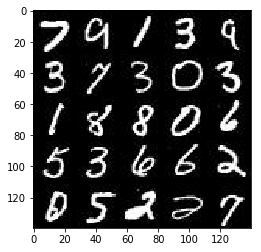

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

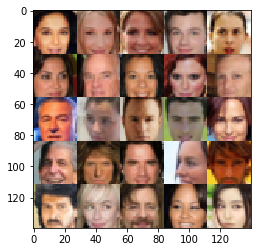

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape = ())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [7]:
def lrelu(x, alpha):
    return tf.maximum(x*alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev = 0.02)
    
    with tf.variable_scope('discriminator', reuse = reuse):
        #input size is 28 x 28 x 3
        #convert to 14 x 14 x 64
        x = tf.layers.conv2d(images, 64,5,strides = 2, kernel_initializer = kinit, padding = 'same')
        x = lrelu(x,alpha)
        
        #convert to 7 x 7 x 128
        x = tf.layers.conv2d(x,128, 5, strides = 2, kernel_initializer = kinit, padding = 'same')
        x = lrelu(x,alpha)
        x = tf.layers.batch_normalization(x, training = True)
        
        #convert to 4 x 4 x 256
        x  = tf.layers.conv2d(x, 256, 5, strides = 2, kernel_initializer = kinit, padding = 'same')
        x = lrelu(x,alpha)
        x = tf.layers.batch_normalization(x, training = True)
        
        x = tf.reshape(x,(-1,4*4*256))
        logits = tf.layers.dense(x,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev = 0.02)
    
    with tf.variable_scope('generator', reuse = (not is_train)):
        #convert to 7 x 7 x 256
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1,7,7,256))
        x = lrelu(x,alpha)
        x = tf.layers.batch_normalization(x, training = is_train)
        
        # convert to 14 x 14 x 128
        x = tf.layers.conv2d_transpose(x, 128, 5, strides = 2, kernel_initializer = kinit, padding = 'same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training = is_train)
        
        # convert to 28 x 28 x 64
        x = tf.layers.conv2d_transpose(x, 64, 5, strides = 2, kernel_initializer = kinit, padding = 'same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training = is_train)
        
        #convert to 28 x 28 x 3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides = 1, kernel_initializer = kinit, padding = 'same')
        
        out = tf.tanh(logits)
        
        
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True, alpha = alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha = alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse = True, alpha = alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) - (1-smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels = tf.ones_like(d_fake_out)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, labels = real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = g_labels))
    
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every = 10, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha = 0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1,1, size= (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict = {input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess,25,input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 2.1046
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 2.7266
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 3.2563
Epoch 1/2... Discriminator Loss: 0.3752... Generator Loss: 3.4338
Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 4.1131
Epoch 1/2... Discriminator Loss: 0.3983... Generator Loss: 4.5558
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 4.6268
Epoch 1/2... Discriminator Loss: 0.3737... Generator Loss: 3.7512
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 4.4686


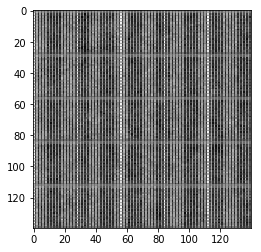

Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 4.7776
Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 4.8727
Epoch 1/2... Discriminator Loss: 0.3395... Generator Loss: 4.8721
Epoch 1/2... Discriminator Loss: 0.3440... Generator Loss: 4.7168
Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 4.7763
Epoch 1/2... Discriminator Loss: 0.3601... Generator Loss: 4.7044
Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 5.0317
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 5.0691
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 4.9226
Epoch 1/2... Discriminator Loss: 0.3437... Generator Loss: 4.8031


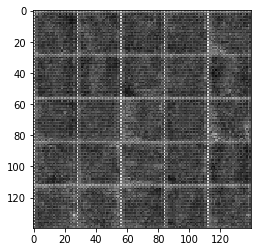

Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 5.1489
Epoch 1/2... Discriminator Loss: 0.3821... Generator Loss: 5.2497
Epoch 1/2... Discriminator Loss: 0.3516... Generator Loss: 4.1899
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 4.1492
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 3.8552
Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 2.3101
Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 3.8976
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 4.5925
Epoch 1/2... Discriminator Loss: 0.3541... Generator Loss: 3.9984
Epoch 1/2... Discriminator Loss: 0.4955... Generator Loss: 2.2763


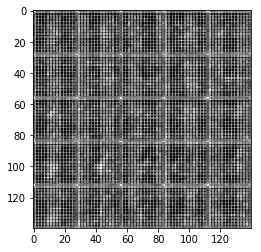

Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 4.2087
Epoch 1/2... Discriminator Loss: 0.3635... Generator Loss: 3.5165
Epoch 1/2... Discriminator Loss: 0.3530... Generator Loss: 4.2097
Epoch 1/2... Discriminator Loss: 0.3529... Generator Loss: 4.4767
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 3.4265
Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 3.8091
Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 3.5537
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 3.8691
Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 4.1904
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 3.4361


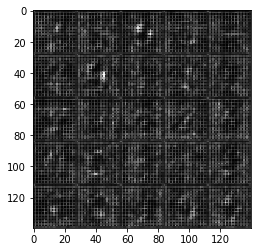

Epoch 1/2... Discriminator Loss: 0.3562... Generator Loss: 3.6655
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.9940
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 3.5795
Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 3.3642
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 3.4865
Epoch 1/2... Discriminator Loss: 0.3612... Generator Loss: 3.6189
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 4.3264
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 3.1931
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 3.8071
Epoch 1/2... Discriminator Loss: 0.3679... Generator Loss: 3.8530


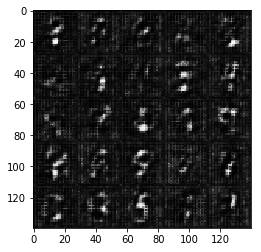

Epoch 1/2... Discriminator Loss: 0.3711... Generator Loss: 3.3297
Epoch 1/2... Discriminator Loss: 0.3826... Generator Loss: 4.3035
Epoch 1/2... Discriminator Loss: 0.3993... Generator Loss: 4.5795
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 3.1563
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 3.5456
Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 3.6399
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 5.6538
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 4.1821
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 3.0414
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 3.3513


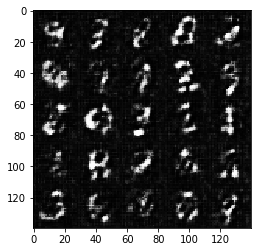

Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 3.5821
Epoch 1/2... Discriminator Loss: 0.3670... Generator Loss: 3.4584
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 3.4318
Epoch 1/2... Discriminator Loss: 0.3734... Generator Loss: 3.2462
Epoch 1/2... Discriminator Loss: 0.3721... Generator Loss: 3.3247
Epoch 1/2... Discriminator Loss: 0.3804... Generator Loss: 4.0110
Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 3.6640
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 3.5143
Epoch 1/2... Discriminator Loss: 0.3729... Generator Loss: 3.6085
Epoch 1/2... Discriminator Loss: 0.3734... Generator Loss: 3.8795


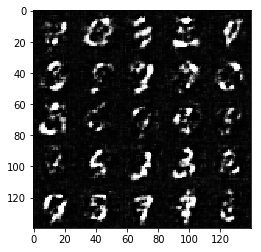

Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 3.3919
Epoch 1/2... Discriminator Loss: 0.3739... Generator Loss: 4.2326
Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 3.3063
Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 3.1929
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 3.1761
Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 3.4103
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 3.6564
Epoch 1/2... Discriminator Loss: 0.3651... Generator Loss: 3.5769
Epoch 1/2... Discriminator Loss: 0.3679... Generator Loss: 3.4820
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 3.9792


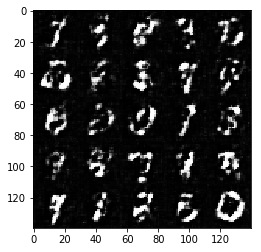

Epoch 1/2... Discriminator Loss: 0.3637... Generator Loss: 3.7564
Epoch 1/2... Discriminator Loss: 0.3654... Generator Loss: 4.0507
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 3.0273
Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 3.4772
Epoch 1/2... Discriminator Loss: 0.3636... Generator Loss: 3.7681
Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 3.4929
Epoch 1/2... Discriminator Loss: 0.3689... Generator Loss: 4.0161
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 3.3856
Epoch 1/2... Discriminator Loss: 0.3643... Generator Loss: 3.8019
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 3.3936


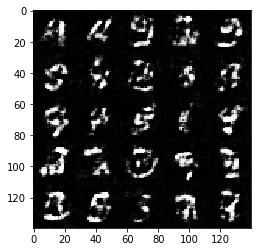

Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 3.9493
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 3.7410
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 3.6231
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 3.3468
Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 3.5418
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 3.5164
Epoch 2/2... Discriminator Loss: 0.3726... Generator Loss: 3.9664
Epoch 2/2... Discriminator Loss: 0.4228... Generator Loss: 4.9021
Epoch 2/2... Discriminator Loss: 0.3936... Generator Loss: 4.2177
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 3.0469


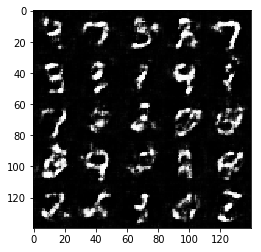

Epoch 2/2... Discriminator Loss: 0.3709... Generator Loss: 3.3523
Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 3.5125
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 3.0867
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 2.9640
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 3.0737
Epoch 2/2... Discriminator Loss: 0.3830... Generator Loss: 3.9202
Epoch 2/2... Discriminator Loss: 0.3851... Generator Loss: 2.9637
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 3.5465
Epoch 2/2... Discriminator Loss: 0.3762... Generator Loss: 3.1443
Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 3.2819


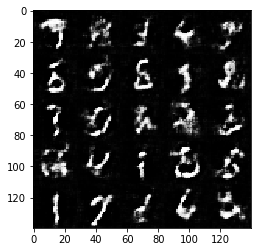

Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 2.9938
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 3.1452
Epoch 2/2... Discriminator Loss: 0.3800... Generator Loss: 3.2680
Epoch 2/2... Discriminator Loss: 0.3738... Generator Loss: 3.3000
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 3.0992
Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 3.9367
Epoch 2/2... Discriminator Loss: 0.3779... Generator Loss: 3.1245
Epoch 2/2... Discriminator Loss: 0.3742... Generator Loss: 3.2522
Epoch 2/2... Discriminator Loss: 0.3850... Generator Loss: 3.0336
Epoch 2/2... Discriminator Loss: 0.3717... Generator Loss: 3.3475


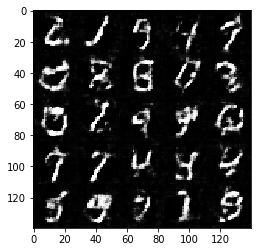

Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 3.4838
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.0847
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 3.3440
Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.0900
Epoch 2/2... Discriminator Loss: 0.3723... Generator Loss: 3.5945
Epoch 2/2... Discriminator Loss: 0.3710... Generator Loss: 3.5141
Epoch 2/2... Discriminator Loss: 0.3714... Generator Loss: 3.3023
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.2111
Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 3.0513
Epoch 2/2... Discriminator Loss: 0.3769... Generator Loss: 3.2320


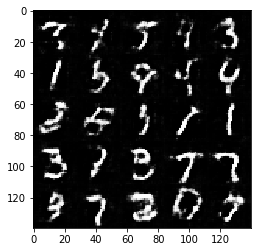

Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 2.8929
Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 3.2002
Epoch 2/2... Discriminator Loss: 0.3776... Generator Loss: 3.2448
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 3.3061
Epoch 2/2... Discriminator Loss: 0.3730... Generator Loss: 3.2729
Epoch 2/2... Discriminator Loss: 0.3840... Generator Loss: 3.0486
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 6.1273
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 3.3997
Epoch 2/2... Discriminator Loss: 0.3746... Generator Loss: 3.6763
Epoch 2/2... Discriminator Loss: 0.3767... Generator Loss: 3.2107


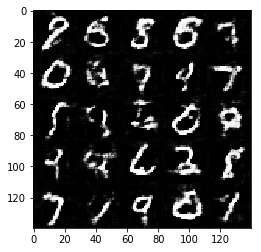

Epoch 2/2... Discriminator Loss: 0.3755... Generator Loss: 3.6216
Epoch 2/2... Discriminator Loss: 0.3681... Generator Loss: 3.6361
Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 3.0728
Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 4.0545
Epoch 2/2... Discriminator Loss: 0.3702... Generator Loss: 3.3907
Epoch 2/2... Discriminator Loss: 0.3732... Generator Loss: 3.2510
Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 3.2830
Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 3.2821
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 3.3146
Epoch 2/2... Discriminator Loss: 0.3692... Generator Loss: 3.5003


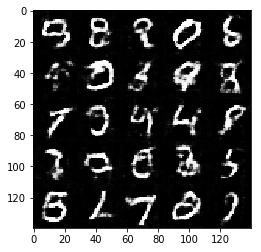

Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 3.1395
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 3.2540
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.2630
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.0967
Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 3.2483
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 3.4194
Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 3.2263
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 3.3542
Epoch 2/2... Discriminator Loss: 0.3755... Generator Loss: 3.2400
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 3.1906


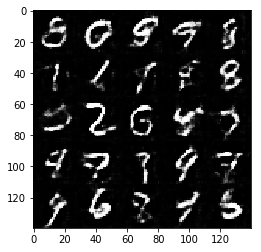

Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 3.2612
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 3.0971
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 3.2190
Epoch 2/2... Discriminator Loss: 0.3800... Generator Loss: 3.6246
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 3.3408
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 3.6660
Epoch 2/2... Discriminator Loss: 0.3779... Generator Loss: 3.4405
Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 3.6103
Epoch 2/2... Discriminator Loss: 0.3817... Generator Loss: 3.1761
Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 4.2801


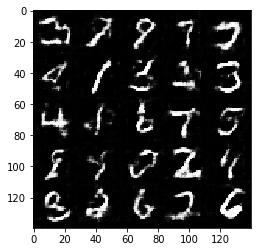

Epoch 2/2... Discriminator Loss: 0.3707... Generator Loss: 3.2728
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 3.7454
Epoch 2/2... Discriminator Loss: 0.3732... Generator Loss: 3.6385
Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 3.3696
Epoch 2/2... Discriminator Loss: 0.4806... Generator Loss: 5.0932
Epoch 2/2... Discriminator Loss: 0.3771... Generator Loss: 3.5844
Epoch 2/2... Discriminator Loss: 0.3710... Generator Loss: 3.3581
Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 3.2274
Epoch 2/2... Discriminator Loss: 0.3769... Generator Loss: 3.2229
Epoch 2/2... Discriminator Loss: 0.3842... Generator Loss: 3.6206


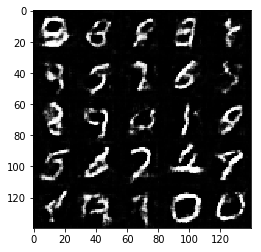

Epoch 2/2... Discriminator Loss: 0.3767... Generator Loss: 3.4532
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 2.5209
Epoch 2/2... Discriminator Loss: 0.3710... Generator Loss: 3.3791
Epoch 2/2... Discriminator Loss: 0.3817... Generator Loss: 3.0792
Epoch 2/2... Discriminator Loss: 0.3752... Generator Loss: 3.3500
Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 3.2913
Epoch 2/2... Discriminator Loss: 0.3681... Generator Loss: 3.5106


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1232... Generator Loss: 0.2888
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 2.3458
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.1185
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 4.3190
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.3695
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 3.6729
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 2.9027


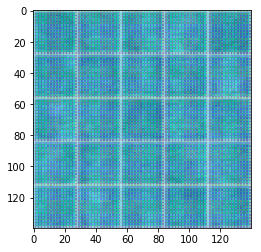

Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.6219
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 4.1041
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 3.3230
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 2.9444
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.2187
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 3.1651
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 2.9400
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 4.1948
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 2.5761
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 4.1584


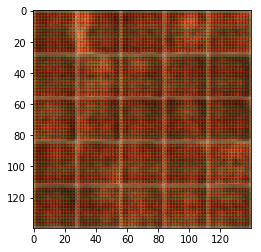

Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 2.9441
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 3.1703
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.2593
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 3.3049
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 2.8574
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.1291
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.1587
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.1268
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.3203


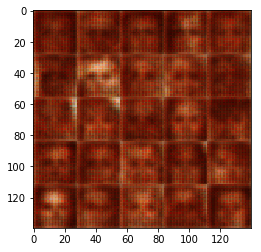

Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 3.3248
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.4951
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 2.9761
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 2.8854
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 2.9362
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 2.7908
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.6530
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 3.3489
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 3.5859
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 3.3106


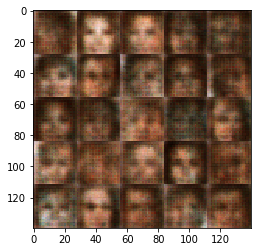

Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 2.9322
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 2.8350
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 3.1513
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 2.7827
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 3.1037
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 4.1364
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.1208
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 3.0719
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.0525
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.1141


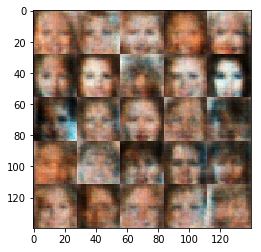

Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.1636
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.0359
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.3242
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 2.8491
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 2.6406
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 2.8316
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 2.9780
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 2.8521
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.0334
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 2.9392


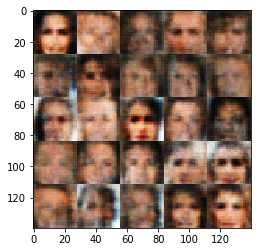

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.0058
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 2.9494
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 2.7152
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.8018
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.1515
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 3.2060
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 3.1303
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 2.9213
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 2.8431
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 3.0186


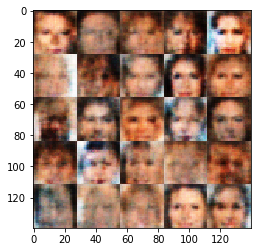

Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 2.8562
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.2420
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 2.9360
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 3.0209
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 3.2903
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 3.0896
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 2.9297
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 2.9103
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.0186


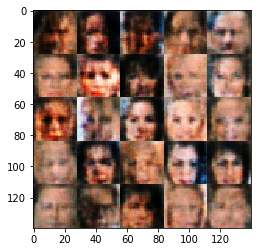

Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.1259
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.0946
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.2204
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.0211
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 2.9972
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.2710
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 3.2071
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 2.9501
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 2.9856
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.1686


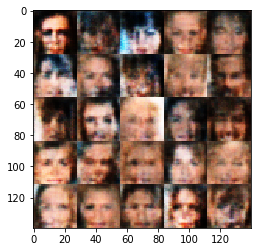

Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.1110
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 2.7940
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 3.1496
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 2.9182
Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 3.0504
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 2.9947
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.1099
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 2.9204
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.0393


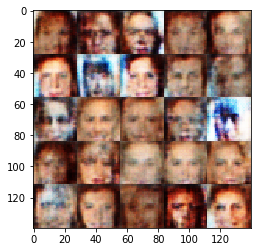

Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 2.9513
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.0264
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 2.9254
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.1594
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 3.0797
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 2.9414
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 2.7548
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 2.8766
Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 3.0394
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 2.9977


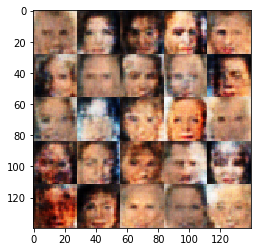

Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 3.0638
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.0188
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 3.0969
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.0517
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 2.9413
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.0040
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.0453
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.9767
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.2906
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.0414


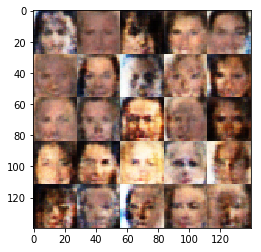

Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 3.0192
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.0425
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.0576
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.2558
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 3.1549
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.2147
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 2.8289
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 2.9548
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 2.9704
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.0993


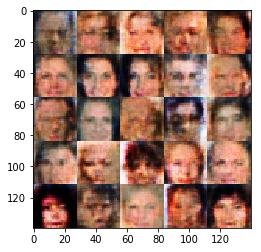

Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.0638
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.2741
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 2.9215
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 3.0029
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 2.9467
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 2.9949
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.1330
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 2.9471
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 2.9344
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 3.0102


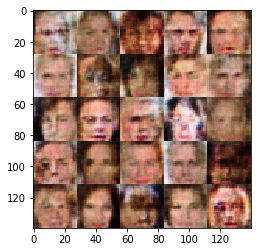

Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 2.9748
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.2670
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.0204
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 2.9950
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.0909
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 3.0517
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 2.8982
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.0664
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.1118
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.0764


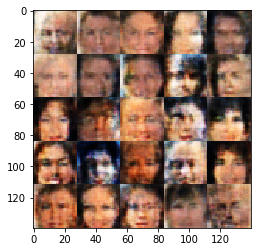

Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 3.3077
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 2.9245
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 2.9733
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 2.9068
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 2.9689
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 2.9557
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.1875
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 2.8201
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.0634


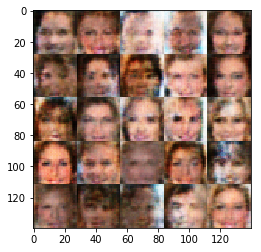

Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 3.0305
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.9537
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 2.9319
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 2.9354
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.0936
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 2.9541
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.0017
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 2.9073
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 2.9580
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.0119


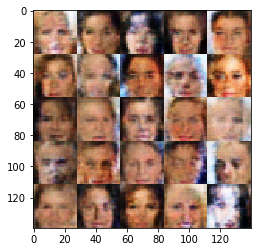

Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.0226
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 2.8013
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.0431
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 2.9494
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 2.9526
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.1916
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.1086
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.0582
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 2.8507
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.1002


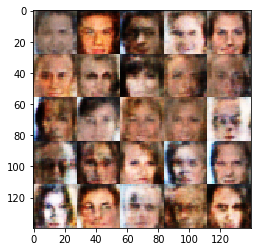

Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.0783
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 2.8798
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 2.9327
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 2.7982
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 3.0809
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.0533
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 2.8736
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 2.8995
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.0322
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 2.9417


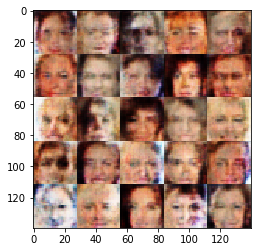

Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 3.0557
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 2.8582
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 2.9905
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 2.8910
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.0848
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.0046
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.0237
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.0171
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 3.0520
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 2.8168


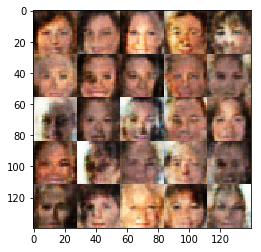

Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.0762
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.0921
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 3.0091
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.0913
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.0803
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.0008
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 2.9967


KeyboardInterrupt: 

In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.